In [1]:
from pandas import read_csv
import matplotlib.pyplot as plt

In [2]:
plt.xkcd()

In [5]:
syscall_syscall = read_csv("syscall-syscall.csv")
syscall_dpdk = read_csv("syscall-dpdk.csv")
syscall_dpdk.head()

,time,tx_packets,rx_packets,drop_rate,avg_latency
0,0,1247794,1182054,0.052249,0.431656
1,1000,1270051,1128638,0.111454,0.453657
2,2000,1173799,1153664,0.017066,0.420048
3,3000,1174163,1162280,0.010159,0.411634
4,4000,1108337,1100950,0.006693,0.389061


Text(0.5, 1.0, 'Packets received back by the sender')

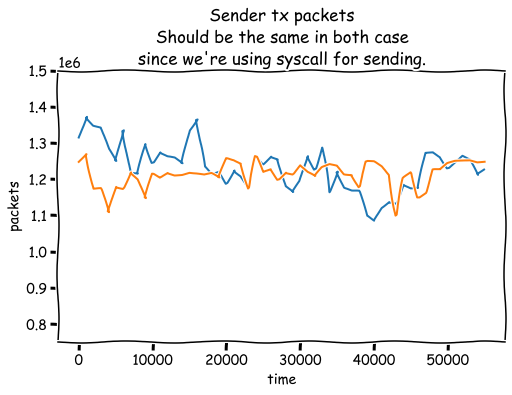

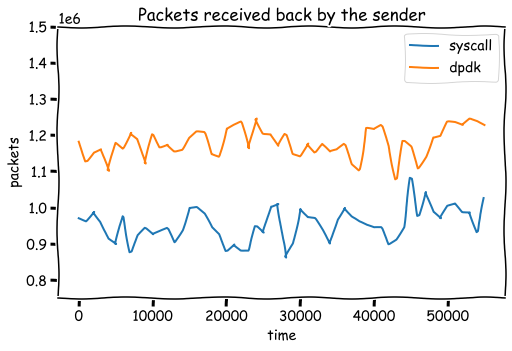

In [4]:
# plot packet stats
lims = (0.75e6, 1.5e6)

fig = plt.figure(figsize=(8, 5))
plt.plot(syscall_syscall["time"], syscall_syscall["tx_packets"], label="syscall")
plt.plot(syscall_syscall["time"], syscall_dpdk["tx_packets"], label="dpdk")
plt.ylabel("packets")
plt.xlabel("time")
plt.ylim(lims)
plt.title("Sender tx packets\nShould be the same in both case\nsince we're using syscall for sending.")

fig = plt.figure(figsize=(8, 5))
plt.plot(syscall_syscall["time"], syscall_syscall["rx_packets"], label="syscall")
plt.plot(syscall_syscall["time"], syscall_dpdk["rx_packets"], label="dpdk")
plt.ylabel("packets")
plt.xlabel("time")
plt.ylim(lims)
plt.legend()
plt.title("Packets received back by the sender")

Text(0.5, 1.0, 'Average latency')

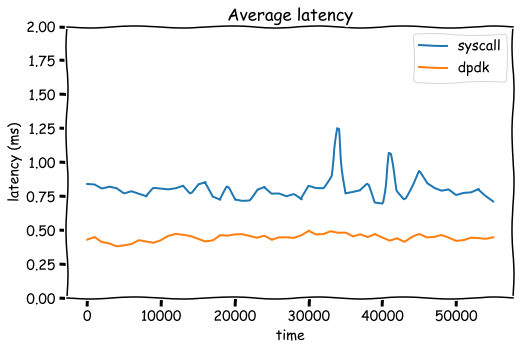

In [6]:
# Plot latency
lims = (0, 2)

fig = plt.figure(figsize=(8, 5))
plt.plot(syscall_syscall["time"], syscall_syscall["avg_latency"], label="syscall")
plt.plot(syscall_syscall["time"], syscall_dpdk["avg_latency"], label="dpdk")
plt.ylabel("latency (ms)")
plt.ylim(lims)
plt.xlabel("time")
plt.legend()
plt.title("Average latency")